# Serine codon landscape

Serine is the only aminoacid that is encoded by two sets of mutationally disconnected codons under the standard genetic code.

- AGY: {AGU,AGC}
- UCN: {UCA,UCC,UCG,UCU}

This leads to a landscape with two isolated fitness peaks that we can easily visualize

## 1. Defining the discrete space

The first thing we need to do is to define the discrete space for the evolutionary random walk. While we provide a generic class DiscreteSpace to define an arbitrary discrete space based on the adjacency matrix and nodes properties on which the transition between states may depend, we are going to use the class SequenceSpace that has specific built-in properties and methods specifically for sequence space.

In [1]:
# Import required libraries
import pandas as pd
from gpmap.src.space import SequenceSpace

After importing the required libraries, we can read the fitness values that we have previously generated. In this artificial example, we assigned fitnesses in the following way:

- w=2 to codons encoding Serine
- w=1 to codons encoding other aminoacides
- w=0 to stop codons

We also added some small perturbation to the fitnesses of the individual codons that could account for codon usage biases, but also allow better separation of the genotypes in the low dimensional representation. We provide different ways to generate this particular landscape

### Direct sequence-function relationship


In [2]:
fpath = '../gpmap/test/data/serine.csv'
data = pd.read_csv(fpath, index_col=0)
data.head()

,function
AAA,1.176405
AAC,1.040016
AAG,1.097874
AAT,1.224089
ACA,1.186756


We can see the simple table that just stores the function value for each sequence, that we will use to create a SequenceSpace object, that has a number of attributes such as number of states, allelese or the alphabet_type, in this case 'rna'

In [3]:
space = SequenceSpace(seq_length=3, alphabet_type='rna', function=data['function'])
space.n_states, space.n_alleles, space.alphabet_type

(64, [4, 4, 4], 'rna')

### Using codon model

Sometimes we may not be able to differentiate between the function or fitnesses of different codons encoding the same aminoacid, but still want to take into account the connectivity at the nucleotide level for visualizing the landscape as in a codon model of evolution.

The following table contains the fitnesses associated to each of the 20 aminoacids

In [5]:
protein_data = pd.read_csv('../gpmap/test/data/serine.protein.csv', index_col=0)
protein_data

,function
protein,
A,1
C,1
D,1
E,1
F,1
G,1
H,1
I,1
K,1


In [7]:
space = SequenceSpace(seq_length=1, alphabet_type='dna',
                      function=protein_data['function'],
                      use_codon_model=True,
                      codon_table='Standard', stop_function=0)
space.n_states, space.n_alleles, space.alphabet_type

(64, [4, 4, 4], 'dna')

### Using CodonSpace class

We also provide a more generic CodonSpace class that does this operation for us so that we only need to provide the aminoacid(s) are are going to be under selection, enabling also to visualizing the structure of the landscape corresponding to aminoacids with certain properties

In [8]:
from gpmap.src.space import CodonSpace

In [9]:
space = CodonSpace(allowed_aminoacids=['S'], codon_table='Standard', add_variation=True, seed=0)
space.n_states, space.n_alleles, space.alphabet_type

(64, [4, 4, 4], 'dna')

Note that we could also test how these landscapes would change under different genetic codes other than the standard. We use biopython module to translate the nucleotide sequence into protein sequence using [NCBI reference](https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi) for different codon tables or genetic codes

## 2. Defining the random walk on the discrete sequence space


### Evolutionary model

Now we can define an evolutionary random walk on the graph representing our sequence space. For convenience, we assume a Weak Selection Weak Mutation model of evolution, such that mutations are always fixed or lost before a new mutation arises. In other words, the population is polymorphic in only one site during a specific period of time. 

As we often want to visualize sequence-function relationships rather than direct organismal fitness, we generally assume a linear relationship between function and fitness, controled by the selective coefficient $s$. Given an effective population size of $N$ under uniform mutation rates, the substitution rate is given by

$$
Q_{ij} =
\begin{cases}
    \frac{Ns(f_j - f_i)}{1 - e^{-Ns(f_j - f_i)}} & \text{if i and j are neighbors}\\
    -\sum_{k \neq i} Q_{ik} & \text{if } i=j\\
    0 & \text{otherwise}
\end{cases}
$$

If we obtain the eigendecomposition of $\mathbf{Q}$

$$
\mathbf{Q} = \sum_m \lambda_m r_m l_m^T
$$

We can calculate the transition matrix after some time $t$

$$
P = e^{Qt} = \sum_m e^{\lambda_m t} r_m l_m^T
$$

If we now condition on starting at genotype $i$ and knowing that $r_1 = 1$ and $l_1 = \pi$ and $\lambda_1 = 0$

$$
P_i = \sum_m e^{\lambda_m t} r_{m,i} l_m^T = e^{\lambda_1 t} r_{1,i} l_1^T + \sum_{m=2} e^{\lambda_m t} r_{m,i} l_m^T = \pi + \sum_{m=2} e^{\lambda_m t} r_{m,i} l_m^T
$$

We can see how the right eigenvalues provide an idea of the weight of the slowly decaying components (small $\lambda$s) depending on the starting genotype.

We can calculate the projection coordinates $u_k$ normalizing the right eigenvectors by the decay rates $\frac{-1}{\lambda_k}$.

$$
u_k = \frac{r_k}{\sqrt{-\lambda}}
$$

This way, the sum of square distances in the low dimensional representation approximates the conmute times between every pair of genotypes ($H_{ij} + H_{ji}$) without having to calculate the whole matrix to generate an embedding. 

$$
H_{ij} + H_{ji} = \sum_{k=2} (u_{k,j} - u_{k,i})^2
$$

### Calculating the coordinates of the visualization

In practice, once we have defined our discrete space, we just need to define an additional random walk on it and numerically calculate the propertly scaled right eigenvectors

In [10]:
from gpmap.src.randwalk import WMWSWalk

In [11]:
rw = WMWSWalk(space)

 There are 3 different ways in which we can provide the scaled effective population size $Ns$:
 
 - Directly through the Ns argument
 - By selecting the expected mean function at stationarity, for instances by selecting the funcion of the wild-type sequence that was used for the experiment.
 - By selecting the percentile of expected mean function at stationarity among the values of all genotypes if we do not have a very clear reference of what could be a functional phenotype
 
In this case, lets try with a mean function at stationarity of 1.5, which implies that a substantial probability would lie on the few genotypes with fitness 2 corresponding to the codons encoding Serine. We can later check what $Ns$ was required to reach that stationary function

In [12]:
rw.calc_visualization(mean_function=1.5)
print('Mean function at stationarity of 1.5 was reached at Ns={:.2f}'.format(rw.Ns))

Mean function at stationarity of 1.5 was reached at Ns=2.13


We can also do the calculations specifying the $Ns=2.13$ and check the mean function at stationarity

In [13]:
rw.calc_visualization(Ns=rw.Ns)
print('Mean function at stationarity of {:.2f}'.format(rw.calc_stationary_mean_function()))

Mean function at stationarity of 1.50


Now the coordinates of the embeding is stored in the attribute 'nodes_df' of the object WMWSWalk as a standard pandas DataFrame object that we can use for plotting

In [14]:
rw.nodes_df.head()

,1,2,3,4,5,6,7,8,9,function,stationary_freq
AAA,-0.407809,-0.868657,-0.077718,-0.881548,0.062915,-1.472113,-0.606878,0.747800,0.084495,1.176405,0.013284
AAC,-0.629546,-0.280195,0.609875,0.203410,0.112414,-0.803236,-0.580154,0.518404,0.318869,1.040016,0.009940
AAG,-0.391836,-0.755214,-0.062261,-0.091489,1.218857,-1.151346,-0.585332,0.711375,0.023780,1.097874,0.011241
AAT,-0.692525,-0.172760,-0.678345,0.175421,0.145847,-0.818042,-0.591270,0.594482,0.109684,1.224089,0.014702
ACA,0.249562,-0.195756,0.026722,-0.982567,-0.188218,-0.845135,0.357074,0.301585,0.056764,1.186756,0.013580


Additionally, we can extract the edges as a dataframe for plotting by storing the adjacency relationships between pairs of genotypes. Note that for efficiency we only provide the indexes, so nodes_df should remain in the given order for the relationships to be maintained in the plots

In [35]:
edges_df = rw.space.get_edges_df()
edges_df.head()

,i,j
0,0,1
1,0,2
2,0,3
3,1,0
4,1,2


## 3. Visualizing the landscape

As the output of the visualization is a simple dataframe with the coordinates, it allows plotting with any library or other programming language. However, we also provide some functions to facilitate the user this job using different libraries for different funcitonalities

- [matplotlib](https://matplotlib.org/) for regular plots
- [plotly](https://plotly.com/python/) for interactive plots
- [datashader](https://datashader.org/) for fast rendering of large landscapes

We simply want to plot the graph representing sequence space, where nodes are represented by points and there is a line between then whenever there is an edge between them. Thus, we divide the plotting into two basic and flexible functions to build more complex plots using different plotting libraries as we will show later.

- nodes plotting
- edges plotting

In [17]:
import gpmap.src.plot as plot

### Using matplotlib

We can start by creating an empty figure and axes for plotting.

For plotting the nodes, we just need to provide the dataframe 'nodes_df' with the embedding and specify which dimensions we want to show and what we want to color by, as well as other classical parameters as size or edge color and width, as in a regular scatterplot.

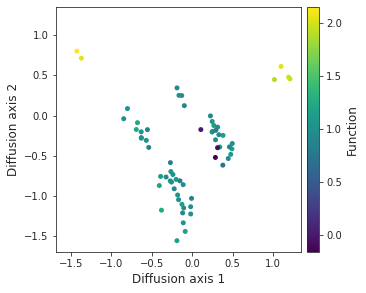

In [26]:
fig, axes = plot.init_fig(1, 1, colsize=5, rowsize=4.5)
plot.plot_nodes(axes, rw.nodes_df, x='1', y='2', color='function', size=25)

We can either color by a column in the dataframe or specify a fixed color. The same goes for the node size

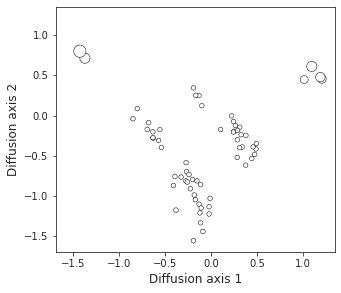

In [31]:
fig, axes = plot.init_fig(1, 1, colsize=5, rowsize=4.5)
plot.plot_nodes(axes, rw.nodes_df, x='1', y='2', color='white', size='stationary_freq',
                edgecolor='black', lw=0.5, min_size=20, max_size=150)

Now we can easily add the edges to show how genotypes are connected to each other by single point mutations

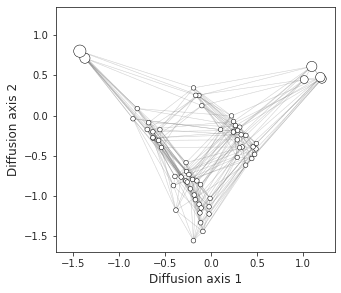

In [38]:
plot.plot_edges(axes, rw.nodes_df, edges_df=edges_df)
fig

We provide a more compact function to plot both elements in a single step easily

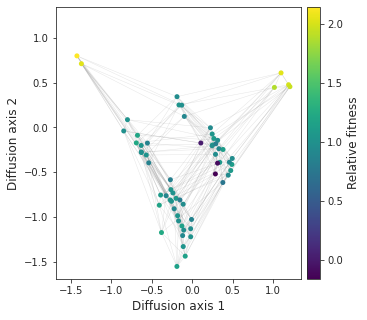

In [44]:
fig, axes = plot.init_fig(1, 1, colsize=5, rowsize=5)
plot.plot_visualization(axes, rw.nodes_df, edges_df=edges_df, x='1', y='2',
                        nodes_color='function', nodes_cmap_label='Relative fitness',
                        nodes_size=25, edges_alpha=0.2)

Now we have a nice visualization of the structure of the landscape, where we can see two main fitness peaks that are separated appart from each other along diffusion axis 1, while diffusion axis 2 separates genotypes with high fitness from those with low fitness that are at an increasing number of mutations away. 

The natural question now is: what are the sequences at the different fitness peaks? A simple approach to that question is to color genotypes systematically according their sequence or subsequence, which we can do if we have some guess about the nature of the fitness peaks. In this case we do have a very reasonable guess, which is the two isolated sets of codons that encode Serine, so we can highlight directly those sets of sequences and see where they lay in the embedding

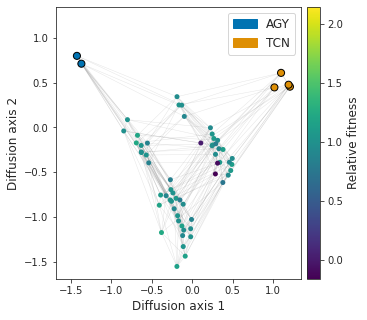

In [45]:
plot.highlight_genotype_groups(axes, rw.nodes_df, genotype_groups=['TCN', 'AGY'],
                               x='1', y='2', size=50)
fig

We can indeed see that the peaks correspond to the different sets of codons that code for the Serine aminoacid. However, in a real scenario, we would rarely know beforehand what sequences compose the different fitness peaks. A useful strategy is to make a series of plots in which we serially color by the alleles at each position. This way, we can follow how a genotype or groups of genotypes light up in each position for the different alleles, so we can effectively read the genotypes from this layout easily, at least when the number of genotypes is low as in here.

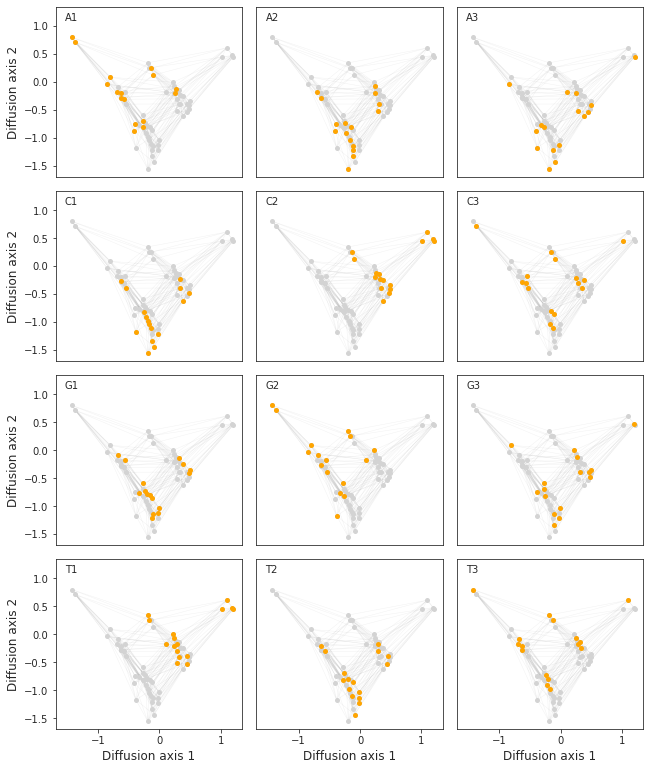

In [46]:
plot.figure_allele_grid(rw.nodes_df, edges_df=edges_df, x='1', y='2', nodes_size=25)